[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


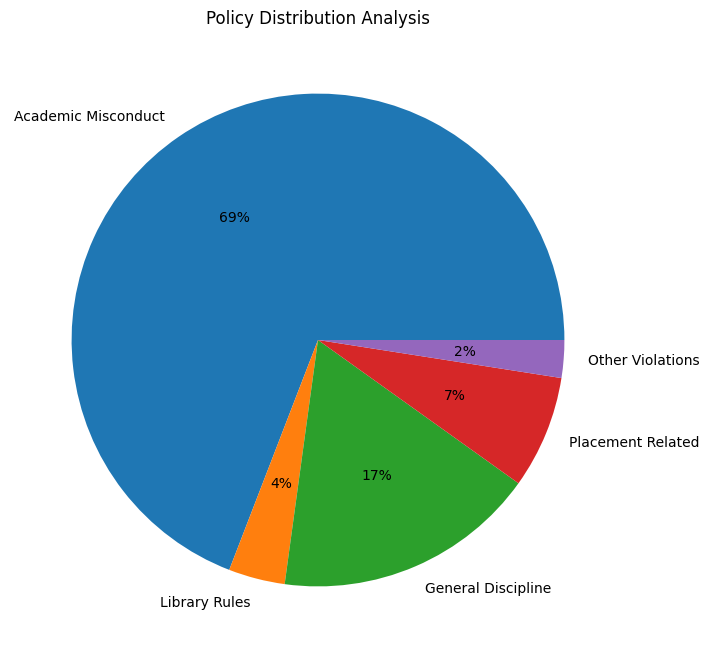

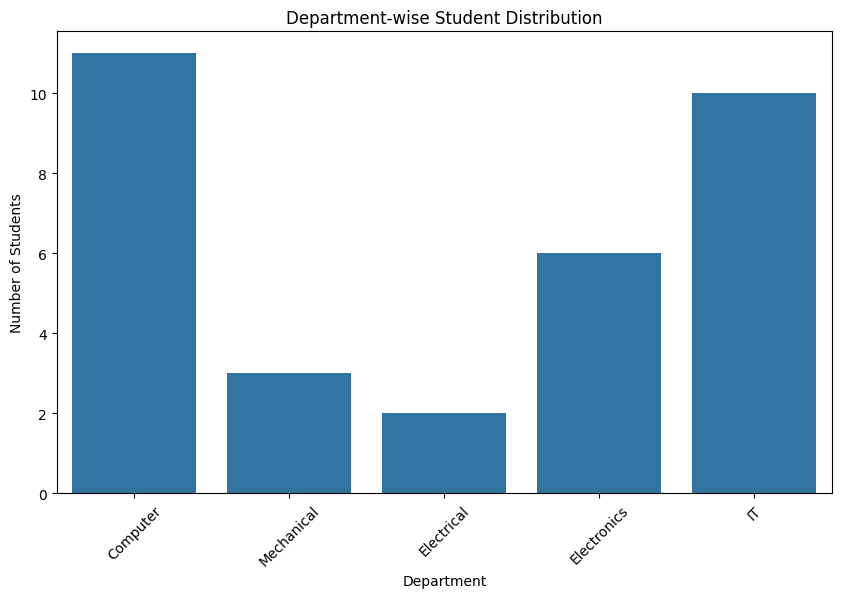

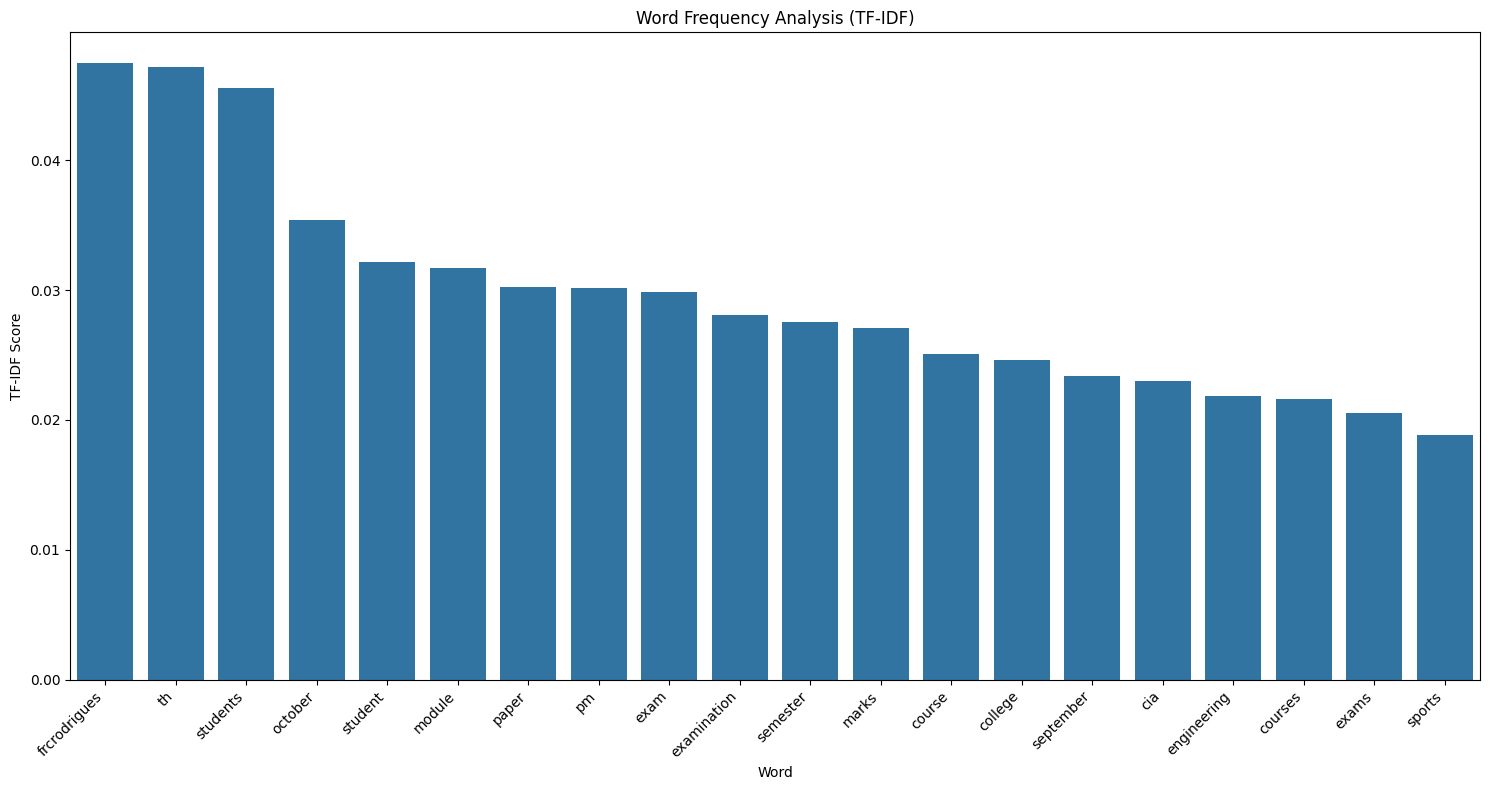


Top 10 Most Important Terms (TF-IDF):
             word  frequency
377  frcrodrigues   0.047465
905            th   0.047188
866      students   0.045552
587       october   0.035421
865       student   0.032124
571        module   0.031688
607         paper   0.030253
625            pm   0.030135
323          exam   0.029836
324   examination   0.028037


In [11]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from collections import Counter

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

# Load additional stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
stop_words = list(ENGLISH_STOP_WORDS) + stopwords.words('english') + ['fcrit', 'fr', 'c', 'rodrigues', 'institute', 'technology']

def preprocess_text(text):
    """Clean and preprocess text"""
    if not isinstance(text, str):
        return ""
    text = re.sub(r'[^\w\s]', '', text.lower())  # Remove special characters
    text = re.sub(r'\d+', '', text)  # Remove numbers
    return text

def extract_policy_distribution(texts):
    """Categorize policies using keyword matching"""
    categories = {
        'Academic Misconduct': ['exam', 'test', 'grade', 'copying', 'malpractice', 'cheating', 'plagiarism'],
        'Library Rules': ['library', 'books', 'journal', 'reading', 'borrowing'],
        'General Discipline': ['attendance', 'dress', 'behavior', 'conduct', 'discipline'],
        'Placement Related': ['placement', 'interview', 'company', 'recruitment', 'job'],
        'Other Violations': ['ragging', 'harassment', 'damage', 'misconduct']
    }

    category_counts = {cat: 0 for cat in categories}

    for text in texts:
        text = preprocess_text(text)
        for category, keywords in categories.items():
            if any(keyword in text for keyword in keywords):
                category_counts[category] += 1

    total = sum(category_counts.values())
    return {k: (v / total) * 100 if total > 0 else 0 for k, v in category_counts.items()}

def extract_department_info(texts):
    """Extract department-related mentions"""
    dept_patterns = {
        'Computer': r'\bcomputer\b|\bcomp\b',
        'Mechanical': r'\bmechanical\b|\bmech\b',
        'Electrical': r'\belectrical\b|\belect\b',
        'Electronics': r'\belectronics\b|\betc\b',
        'IT': r'\binformation technology\b|\bit\b'
    }

    dept_counts = {dept: 0 for dept in dept_patterns}

    for text in texts:
        text = text.lower()
        for dept, pattern in dept_patterns.items():
            if re.search(pattern, text):
                dept_counts[dept] += 1

    return dept_counts

def get_word_frequency_tfidf(texts, n_words=20):
    """Calculate word frequency using TF-IDF"""
    processed_texts = [preprocess_text(text) for text in texts]

    tfidf = TfidfVectorizer(stop_words=stop_words, max_features=1000)
    tfidf_matrix = tfidf.fit_transform(processed_texts)

    feature_names = tfidf.get_feature_names_out() if hasattr(tfidf, "get_feature_names_out") else tfidf.get_feature_names()
    avg_scores = np.mean(tfidf_matrix.toarray(), axis=0)

    word_freq_df = pd.DataFrame({'word': feature_names, 'frequency': avg_scores}).sort_values('frequency', ascending=False)

    return word_freq_df.head(n_words)

def plot_results(policy_dist, dept_dist, word_freq):
    """Plot analysis results"""
    plt.figure(figsize=(10, 8))
    plt.pie(policy_dist.values(), labels=policy_dist.keys(), autopct='%1.0f%%')
    plt.title('Policy Distribution Analysis')
    plt.savefig('policy_distribution_nlp.png', bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(dept_dist.keys()), y=list(dept_dist.values()))
    plt.title('Department-wise Student Distribution')
    plt.xlabel('Department')
    plt.ylabel('Number of Students')
    plt.xticks(rotation=45)
    plt.savefig('department_distribution_nlp.png', bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(15, 8))
    sns.barplot(x='word', y='frequency', data=word_freq)
    plt.title('Word Frequency Analysis (TF-IDF)')
    plt.xlabel('Word')
    plt.ylabel('TF-IDF Score')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('word_frequency_nlp.png', bbox_inches='tight')
    plt.show()

def main():
    """Main function"""
    df = pd.read_csv('newdataset.csv', encoding='latin1', on_bad_lines='skip')
    if 'Data' not in df.columns:
        raise ValueError("The dataset does not contain a column named 'Data'")

    texts = df['Data'].fillna('').tolist()

    policy_distribution = extract_policy_distribution(texts)
    department_distribution = extract_department_info(texts)
    word_frequencies = get_word_frequency_tfidf(texts)

    plot_results(policy_distribution, department_distribution, word_frequencies)

    print("\nTop 10 Most Important Terms (TF-IDF):")
    print(word_frequencies.head(10))

if __name__ == "__main__":
    main()
